In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [2]:
fishes = 4

In [99]:
from sklearn.mixture import GaussianMixture
import sklearn.cluster as cl
import sklearn.metrics as mt
import random

class EMAlgorithmFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    """
    Representation of a Gaussian mixture model probability distribution. 
    GMMs are probabilistic models that assume all the data points are generated 
    from a mixture of several Gaussian distributions with unknown parameters.

    The EM algorithm is an iterative approach that cycles between two modes:
    E-Step. Estimate the missing variables in the dataset.
    M-Step. Maximize the parameters of the model in the presence of the data.
    """
    def __init__(self):
        self.model = GaussianMixture(n_components=4,
                                     covariance_type='full',
                                     tol=0.01,
                                     max_iter=1000)
        self.clusters = {}
        
    
    def choose_action(self, view: np.ndarray):
                        
        cluster_id = self.model.predict([view])
        #choice = random.sample(list(self.clusters[str(prediction)]), 1)
        prediction = np.mean(self.clusters[str(cluster_id[0])], axis=0)
        
        speed = prediction[0]
        turn = prediction[1]
        
        # turn correction for walls avoidance
        turn = self.avoid_walls(view, turn)
        
        return speed, turn
    
    def avoid_walls(self, view, turn):
        """
        Forces to turn a fish in a random direction
        if in a view's raycast of the walls
        a wall in the front of a fish is detected to near

        Parameters
        ---------
        view : array_like
            The observations of the virtual fish
        turn : float
            Turn predicted by a model that is to modify

        Returns
        ---------
        turn : float
            Original or modified turn depending on the wall distance
        """
        param = random.randint(-5, 5)
        
        if param == 0:
            param = random.randint(5, 11)
        
        if view[6] > 0.9:
            return param * np.pi
        else:
            return turn
        
 
    def fit(self, dset):
        """
        Learns parameters and runs the the two steps of EM Algorithm 
        until the average log-likelihood converges.
        """
        actions = dset[:]["actions"]
        views = dset[:]["views"]
        
        # Train 
        self.model.fit(views)
                
        #collect clustercenters as dictionary
        for center in range(len(self.model.means_)):
            self.clusters[str(center)] = []
        
        #assign data to clustercenters
        for point in dset:
            prediction = self.model.predict([point["views"]])[0]
            self.clusters[str(prediction)] += [point["actions"]]
            
        #print(self.clusters[str(3)])
    
model = EMAlgorithmFishModel()

In [100]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [5]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [101]:
model.fit(dset)

In [102]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=5000)

100%|██████████| 4999/4999 [05:56<00:00, 14.02it/s]


In [103]:
f = generator.as_io_file(track)
f.save_as("output/em_algorithm.hdf5")

<HDF5 file "4947c722-885d-4eac-ba7b-1647e53bec13" (mode r+)>

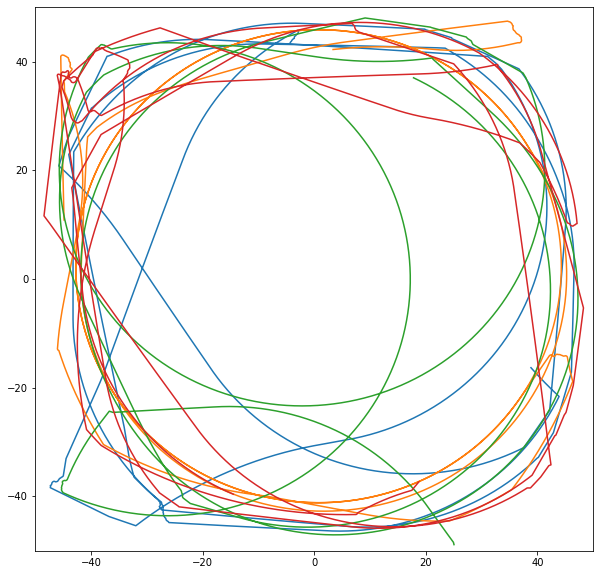

In [104]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()